# Dinâmica Day 7 - Sistemas de Recomendação
Aluno: Guilherme Savaio Marquerie Rodriguez
 
RID: 4116

## 1) Definição do Modelo

### 1.1) Upload das bibliotecas

In [2]:
import pandas as pd
import numpy as np
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt

### 1.2) Upload dos arquivos

In [6]:
uploaded = files.upload()

Saving DNC_products_dataset.csv to DNC_products_dataset (1).csv


### 1.3) Leitura dos Dataframes

In [7]:
df_order_items = pd.read_csv('DNC_order_items_dataset.csv').drop(columns = 'Unnamed: 0')
df_order = pd.read_csv('DNC_orders_dataset.csv').drop(columns = 'Unnamed: 0')
df_order_reviews = pd.read_csv('DNC_order_reviews_dataset.csv').drop(columns = 'Unnamed: 0')
df_products = pd.read_csv('DNC_products_dataset.csv').drop(columns = 'Unnamed: 0')

In [8]:
df_order_items.head()

,order_id,order_item_id,product_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90


In [9]:
df_order_items.shape

(112650, 4)

In [10]:
df_order.head()

,order_id,customer_id,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered


In [11]:
df_order.shape

(99441, 3)

In [12]:
df_order_reviews.head()

,review_id,order_id,review_score
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5


In [13]:
df_order_reviews.shape

(99224, 3)

In [14]:
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,625.0,20.0,17.0,13.0


In [15]:
df_products.shape

(32951, 8)

### 1.4) Qual modelo será feito?
R: Com base nos datasets, poderá ser realizado um modelo Client ou Item Based. Aparentemente um modelo Content Based haveria uma considerável dificuldade em realiza-lo, visto que as informações que temos são dimensões (não aplicável) e categoria.

## 2) Exploração dos Dados

### 2.1) Avaliar os valores presentes em algumas colunas

In [16]:
df_order['order_status'].value_counts()
# Conclusão: Irei considerar apenas os produtos entregues (delivered)

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [17]:
df_order_reviews['review_score'].value_counts()
# Conclusão: As notas vão de 1 a 5

5    57328
4    19142
1    11424
3     8179
2     3151
Name: review_score, dtype: int64

In [18]:
# Verificar intervalo dos preços
df_order_items['price'].describe()

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

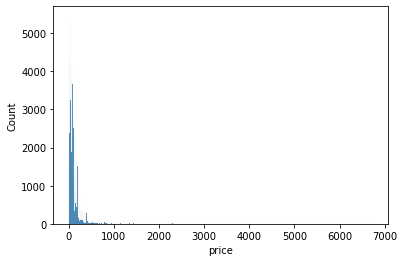

In [19]:
# Análise Gráfica
plt.figure(1)
sns.histplot(data = df_order_items, x = 'price')

### 2.2) Dataframes e Colunas de Interesse
Será utilizado:
- df_order_reviews 
  - order_id
  -	review_score
- df_order
  - order_id	
  - customer_id
  -	order_status
- df_order_items
  - product_id
  - order_id

Será construido um sistema de recomedação que apenas considere os produtos "delivered" e também apenas considere os produtos que tenham um número mínimo de 5 Avaliações. Além disso, se tratando de um e-commerce de variedades, será considerado apenas produtos com valores competitivos de mercado (até 200 reais). Visto que valores maiores que esses, podem ser uma recomendação falha ao cliente.

## 3) Estruturação dos dados

## 3.1) Tratamento dos dataframes

In [20]:
df_order.isna().sum() # Sem colunas nulas

order_id        0
customer_id     0
order_status    0
dtype: int64

In [21]:
df_order_reviews.isna().sum() # Sem colunas nulas

review_id       0
order_id        0
review_score    0
dtype: int64

In [22]:
df_order_items.isna().sum() # Sem colunas nulas

order_id         0
order_item_id    0
product_id       0
price            0
dtype: int64

In [23]:
# Filtragem do df_order
df_order = df_order[df_order['order_status'] == 'delivered']

## 3.2) Merge dos dataframes

In [24]:
df1 = df_order.merge(df_order_reviews[['order_id',	'review_score']], how = 'left', on = 'order_id')
df1.head()

,order_id,customer_id,order_status,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,5.0


In [25]:
df = df1.merge(df_order_items, how = 'left', on = 'order_id')
df.head()

,order_id,customer_id,order_status,review_score,order_item_id,product_id,price
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,4.0,1,87285b34884572647811a353c7ac498a,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,4.0,1,595fac2a385ac33a80bd5114aec74eb8,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,5.0,1,aa4383b373c6aca5d8797843e5594415,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,5.0,1,d0b61bfb1de832b15ba9d266ca96e5b0,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,5.0,1,65266b2da20d04dbe00c5c2d3bb7859e,19.90


In [26]:
df.shape # Conclusão: Massa interessante de trabalho

(110840, 7)

In [27]:
df.isna().sum() # Conclusão: Número de NA insignificante perto do tamanho do df
# Solução: Retirar

order_id           0
customer_id        0
order_status       0
review_score     827
order_item_id      0
product_id         0
price              0
dtype: int64

### 3.3) Tratamento do DataFrame de trabalho

In [28]:
# Retirada das colunas NA
df.dropna(inplace = True)

In [29]:
# Double check
df.isna().sum()

order_id         0
customer_id      0
order_status     0
review_score     0
order_item_id    0
product_id       0
price            0
dtype: int64

In [30]:
# Retirar preços acima de 200
df = df[df['price'] <= 200]

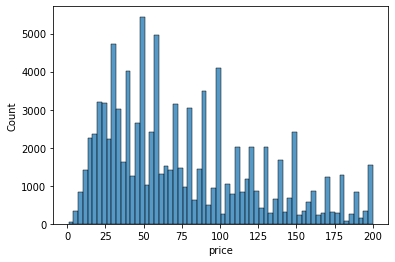

In [31]:
# Verificar nova distribuição de preços
sns.histplot(data = df, x = 'price')

## 3.4) Seleção de Features

In [32]:
df = df[['customer_id', 'product_id','review_score']] # Apenas essas features são necessárias para trabalhar

In [33]:
df.shape

(97129, 3)

In [34]:
df.head()

,customer_id,product_id,review_score
0,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,4.0
1,b0830fb4747a6c6d20dea0b8c802d7ef,595fac2a385ac33a80bd5114aec74eb8,4.0
2,41ce2a54c0b03bf3443c3d931a367089,aa4383b373c6aca5d8797843e5594415,5.0
3,f88197465ea7920adcdbec7375364d82,d0b61bfb1de832b15ba9d266ca96e5b0,5.0
4,8ab97904e6daea8866dbdbc4fb7aad2c,65266b2da20d04dbe00c5c2d3bb7859e,5.0


# 4) Tratamento de Dados e construção de Pipeline

In [77]:
def start_pipeline(dataf):
  return dataf.copy()

def melhores_avaliados(dataf):
  return dataf.groupby(by='product_id', as_index=False) \
    .agg({'customer_id': pd.Series.nunique,
          'review_score': np.mean}) \
    .rename(columns={'review_score': 'review_score_avg'}) \
    .set_index('product_id') \
    .sort_values('review_score_avg', ascending = False) 
    #.loc[df_agrupado_produtos_score['customer_id'] > 10] 
    #.drop(columns = 'customer_id')

def cont_usuario(dataf):
  return dataf.groupby(by='customer_id',as_index = False) \
    .agg({'product_id': pd.Series.nunique}) \
    .rename(columns = {'product_id': 'product_id'}) \
    .set_index('customer_id') \
    .sort_values('product_id', ascending = False)

def mais_avaliados(dataf):
  return dataf.groupby(by='product_id', as_index=False) \
    .agg({'customer_id': pd.Series.nunique}) \
    .rename(columns={'customer_id': 'customer_id_count'}) \
    .set_index('product_id') \
    .sort_values('customer_id_count', ascending = False) \
    #.loc[df_agrupado_produtos_top['customer_id_count'] > 10]

# pegando os melhores/mais
def get_n_top_values(dataf, n):
  return dataf.head(n) \
    .index \
    .tolist()

### 4.1) Execução da Pipeline

In [36]:
top_avaliacoes = df \
  .pipe(start_pipeline) \
  .pipe(melhores_avaliados) \
  .pipe(get_n_top_values, n = 1500)

In [37]:
top_vendas = df \
  .pipe(start_pipeline) \
  .pipe(mais_avaliados) \
  .pipe(get_n_top_values, n = 10)

In [78]:
top_user_ids = df \
  .pipe(start_pipeline) \
  .pipe(cont_usuario) \
  .pipe(get_n_top_values, n = 1000)

In [38]:
top_avaliacoes[:9]

['00066f42aeeb9f3007548bb9d3f33c38',
 '8fa15c06c596b8e4c43a9ff94ed8b410',
 '878446a0acbf50aaffcad66218c018ea',
 '878e6a7350b5ddcf85419728d254e1b2',
 '87a9ce65cf1cfe4f8a81d3c25f0b8874',
 '87ac7e3e844a79b97f7b98cecfbc69db',
 '87b193bb0fb52703cade96b1ffd8c233',
 '87b42927619008f877bfcdd5068e7edf',
 '87b489e8ad10cd2b4e631cc1af34ff00']

In [39]:
top_vendas

['99a4788cb24856965c36a24e339b6058',
 'aca2eb7d00ea1a7b8ebd4e68314663af',
 '422879e10f46682990de24d770e7f83d',
 'd1c427060a0f73f6b889a5c7c61f2ac4',
 '389d119b48cf3043d311335e499d9c6b',
 '53b36df67ebb7c41585e8d54d6772e08',
 '368c6c730842d78016ad823897a372db',
 '53759a2ecddad2bb87a079a1f1519f73',
 '154e7e31ebfa092203795c972e5804a6',
 '2b4609f8948be18874494203496bc318']

## 5) Criação do Modelo

### 5.1) Matriz de relacionamento

In [40]:
# Matriz de relacionamento dos produtos mais vendidos
matriz_de_relacionamento_top_avaliacoes = df[df['product_id'].isin(top_avaliacoes)] \
  .pivot_table(index='product_id', columns = 'customer_id', values = 'review_score').fillna(0)

matriz_de_relacionamento_top_avaliacoes.shape

(1500, 1984)

In [85]:
# Matriz de relacionamento dos usuarios
matriz_de_relacionamento_user_sampled = df[df['customer_id'].isin(top_user_ids)] \
  .pivot_table(index = 'customer_id', columns = 'product_id', values = 'review_score').fillna(0)

matriz_de_relacionamento_user_sampled.shape

(1000, 1980)

### 5.2) Matriz de similaridade

In [41]:
# Fazendo a matriz de similaridade dos produtos
from sklearn.metrics.pairwise import cosine_similarity

cos_produtos = cosine_similarity(matriz_de_relacionamento_top_avaliacoes)

print(cos_produtos)
cos_produtos.shape

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


(1500, 1500)

In [100]:
x = pd.DataFrame(cos_produtos)
set_ = set()
listx =[]
for col in x.columns:
  listx.append(x[col].sum())

listx
  
  

[1.0,
 1.0,
 0.9999999999999998,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999999999999,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999999999998,
 0.9999999999999998,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999999999998,
 1.0,
 1.0,
 0.9999999999999998,
 1.0,
 0.9999999999999998,
 1.7071067811865472,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999999999998,
 1.0,
 1.0,
 0.9999999999999998,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999999999998,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999999999998,
 0.9999999999999999,
 1.0,
 1.0,
 1.0,
 0.9999999999999998,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999999999998,
 1.0,
 1.0,
 0.9999999999999998,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999999999998,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999999999998,
 1.0,
 1.0,
 1.0

In [81]:
# Matriz de similaridade dos usuarios
cos_user = cosine_similarity(matriz_de_relacionamento_user_sampled)

print(cos_user)
cos_user.shape

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


(1000, 1000)

## 6) Testes do Modelo

In [42]:
# Função de Recomendação

def recomendar(id_produto):
  print(f'Produto de interesse: {id_produto}')
  try: 
    produto_idx = matriz_de_relacionamento_top_avaliacoes.index.tolist().index(id_produto)
    # mapear os mais prox
    closest_10_produts = np.argsort(-cos_produtos[produto_idx])[1:11]
    print(f'Retornando 10 livros mais próximos de: {id_produto}.')
    return matriz_de_relacionamento_top_avaliacoes.index[closest_10_produts].tolist()
  except ValueError as e:
    print(f'{id_produto}, não está incluso na matriz de recomendação. Retornando os 10 mais avaliados')
    return top_vendas

In [64]:
# Teste Direcionado
import random
produto_desejado = random.choice(top_avaliacoes)
recomendar(produto_desejado)

Produto de interesse: 8eddc081294df4f0672aedec8a5b249c
Retornando 10 livros mais próximos de: 8eddc081294df4f0672aedec8a5b249c.


['00066f42aeeb9f3007548bb9d3f33c38',
 '8f0877b2fd784f6948e606be7f04744c',
 '8effae0c3be3eab7870860070ca5e51a',
 '8eea5d1c23054af9c31cbac7f9b27af3',
 '8ee57a1f636eb2e009706bbdb0818ecc',
 '8ee15ce472d128e8ea95d9a24c2d397c',
 '8edf8f0889f2cf40d743f3b983aebd3b',
 '8eda2f0e6d437afc08f71ac4b3b380a4',
 '8ed9e6b1cbb80b223b70376a8659bee0',
 '8ec82b20020236063c807e2b9fa43bff']

In [106]:
# Alternativa
produto_desejado = random.choice(top_avaliacoes)
print(f'Produto de Interesse: {produto_desejado}')

produto_idx = matriz_de_relacionamento_top_avaliacoes.index.tolist().index(produto_desejado)
print(f'Produto de id:{produto_desejado}, tem índice {produto_idx}')

closest_10_produts = np.argsort(-cos_produtos[produto_idx])[:10]


for i in zip(matriz_de_relacionamento_top_avaliacoes.index[closest_10_produts], cos_produtos[produto_idx][closest_10_produts]):
    print(f"Produti {i[0]} tem similaridade {i[1]:.5f} com Produto {produto_desejado}")

Produto de Interesse: 80aed7c1df22a03593fdd335531bdc72
Produto de id:80aed7c1df22a03593fdd335531bdc72, tem índice 387
Produti 80aed7c1df22a03593fdd335531bdc72 tem similaridade 1.00000 com Produto 80aed7c1df22a03593fdd335531bdc72
Produti 8f0877b2fd784f6948e606be7f04744c tem similaridade 0.00000 com Produto 80aed7c1df22a03593fdd335531bdc72
Produti 8effae0c3be3eab7870860070ca5e51a tem similaridade 0.00000 com Produto 80aed7c1df22a03593fdd335531bdc72
Produti 8eea5d1c23054af9c31cbac7f9b27af3 tem similaridade 0.00000 com Produto 80aed7c1df22a03593fdd335531bdc72
Produti 8ee57a1f636eb2e009706bbdb0818ecc tem similaridade 0.00000 com Produto 80aed7c1df22a03593fdd335531bdc72
Produti 8ee15ce472d128e8ea95d9a24c2d397c tem similaridade 0.00000 com Produto 80aed7c1df22a03593fdd335531bdc72
Produti 8edf8f0889f2cf40d743f3b983aebd3b tem similaridade 0.00000 com Produto 80aed7c1df22a03593fdd335531bdc72
Produti 8eddc081294df4f0672aedec8a5b249c tem similaridade 0.00000 com Produto 80aed7c1df22a03593fdd335531